In [66]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import joblib

In [42]:
 !unzip /content/IMDB Dataset.csv.zip -d /content/

unzip:  cannot find or open /content/IMDB, /content/IMDB.zip or /content/IMDB.ZIP.


In [43]:
df = pd.read_csv('/content/IMDB Dataset.csv.zip')
print(df.head())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


Class Distribution



Class distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


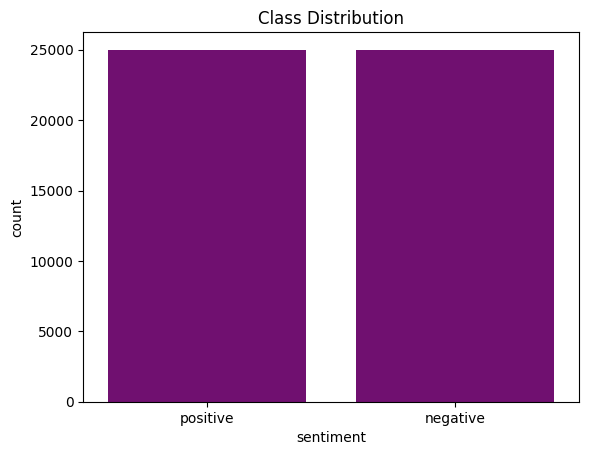

In [44]:
print("Class distribution:")
print(df['sentiment'].value_counts())
sns.countplot(x='sentiment', data=df , color='purple')
plt.title('Class Distribution')
plt.show()

Checking Review Length:

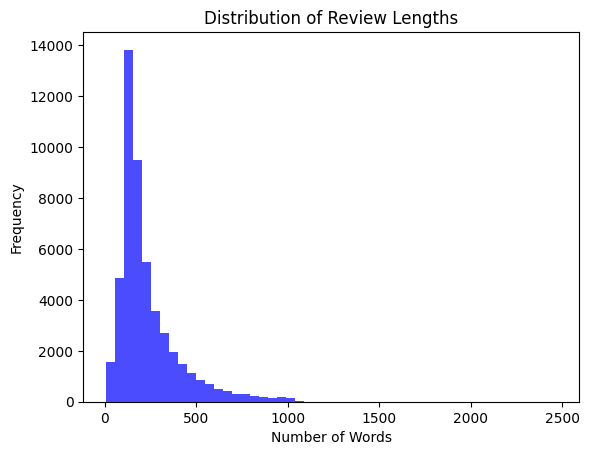

In [45]:
df['review_length'] = df['review'].apply(lambda x: len(x.split()))
plt.hist(df['review_length'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Review Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

Word Cloud For Positive and Negative Reviews:

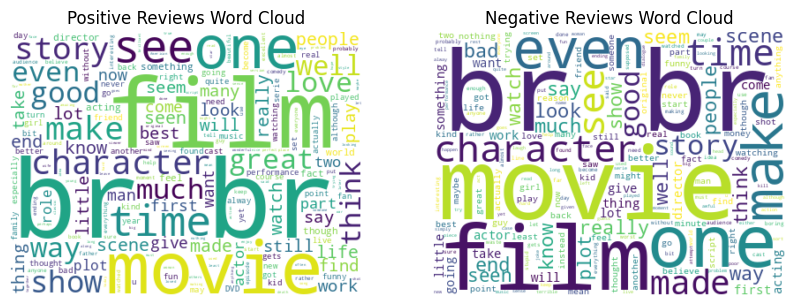

In [46]:
positive_reviews = ' '.join(df[df['sentiment'] == 'positive']['review'])
negative_reviews = ' '.join(df[df['sentiment'] == 'negative']['review'])

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
wordcloud_pos = WordCloud(width=400, height=300, background_color='white').generate(positive_reviews)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.title('Positive Reviews Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
wordcloud_neg = WordCloud(width=400, height=300, background_color='white').generate(negative_reviews)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.title('Negative Reviews Word Cloud')
plt.axis('off')

plt.show()


Feature Engineering:

a) Number of exclamation marks

b) Average word length

c) Number of uppercase words

d) Sentiment polarity using text length (example heuristic)





In [47]:
df['exclamation_count'] = df['review'].apply(lambda x: x.count('!'))
df['avg_word_length'] = df['review'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split()))
df['uppercase_words'] = df['review'].apply(lambda x: sum(1 for word in x.split() if word.isupper()))
df['text_length_polarity'] = df['review_length'] * df['sentiment']


In [48]:
print("Feature Engineering Summary:")
print(df[['review_length', 'exclamation_count', 'avg_word_length', 'uppercase_words', 'text_length_polarity']].describe())

Feature Engineering Summary:
       review_length  exclamation_count  avg_word_length  uppercase_words
count   50000.000000       50000.000000     50000.000000     50000.000000
mean      231.156940           0.983280         4.640676         4.857800
std       171.343997           3.167965         0.340731         5.627519
min         4.000000           0.000000         1.239865         0.000000
25%       126.000000           0.000000         4.417904         1.000000
50%       173.000000           0.000000         4.627006         3.000000
75%       280.000000           1.000000         4.847458         6.000000
max      2470.000000         282.000000        12.290909       162.000000


Pre-processing Data:

Remove missing values

In [49]:
df.dropna(inplace=True)
X = df['review']
y = df['sentiment']


Train Test Split:

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Text Vectorization

In [51]:
vectorizer_count = CountVectorizer(stop_words='english')
vectorizer_tfidf = TfidfVectorizer(stop_words='english')

In [52]:
X_train_count = vectorizer_count.fit_transform(X_train)
X_test_count = vectorizer_count.transform(X_test)

X_train_tfidf = vectorizer_tfidf.fit_transform(X_train)
X_test_tfidf = vectorizer_tfidf.transform(X_test)

MultiNomialNb:

In [53]:
nb_params = {'alpha': [0.1, 0.5, 1.0]}
nb_model = GridSearchCV(MultinomialNB(), nb_params, cv=3, scoring='accuracy')
nb_model.fit(X_train_tfidf, y_train)

GridSearchCV(cv=3, estimator=MultinomialNB(),
             param_grid={'alpha': [0.1, 0.5, 1.0]}, scoring='accuracy')

In [54]:
nb_best_model = nb_model.best_estimator_
y_pred_nb = nb_best_model.predict(X_test_tfidf)
nb_accuracy = accuracy_score(y_test, y_pred_nb)
print("Naive Bayes Accuracy:", nb_accuracy)
print("Best Parameters:", nb_model.best_params_)
print("Classification Report:\n", classification_report(y_test, y_pred_nb))

Naive Bayes Accuracy: 0.8652
Best Parameters: {'alpha': 1.0}
Classification Report:
               precision    recall  f1-score   support

    negative       0.86      0.88      0.87      4961
    positive       0.88      0.85      0.86      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



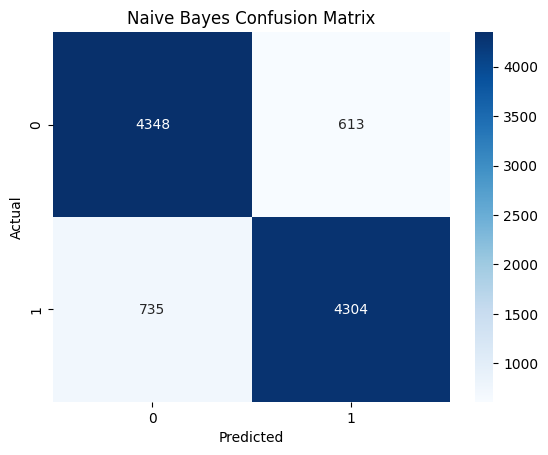

In [55]:
conf_mat_nb = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(conf_mat_nb, annot=True, fmt='d', cmap='Blues')
plt.title('Naive Bayes Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

RandomForest Classifier:

In [56]:
rf_params = {'n_estimators': [50, 100, 200], 'max_depth': [10, 20, None]}
rf_model = GridSearchCV(RandomForestClassifier(), rf_params, cv=3, scoring='accuracy')
rf_model.fit(X_train_tfidf, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [10, 20, None],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [57]:
y_pred_rf = rf_model.best_estimator_.predict(X_test_tfidf)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest Best Params:", rf_model.best_params_)
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.8657
Random Forest Best Params: {'max_depth': None, 'n_estimators': 200}
Classification Report:
               precision    recall  f1-score   support

    negative       0.86      0.87      0.87      4961
    positive       0.87      0.86      0.87      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



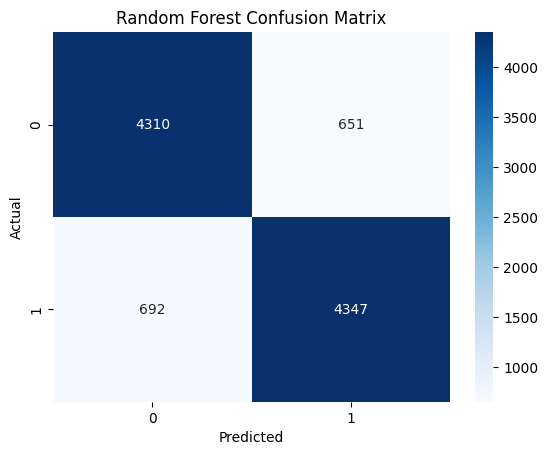

In [58]:
conf_mat_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(conf_mat_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Logistic Regression



In [59]:
lr_params = {'C': [0.01, 0.1, 1, 10]}
lr_model = GridSearchCV(LogisticRegression(max_iter=500), lr_params, cv=3, scoring='accuracy')
lr_model.fit(X_train_tfidf, y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(max_iter=500),
             param_grid={'C': [0.01, 0.1, 1, 10]}, scoring='accuracy')

In [60]:
y_pred_lr = lr_model.best_estimator_.predict(X_test_tfidf)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Logistic Regression Best Params:", lr_model.best_params_)
print("Classification Report:\n", classification_report(y_test, y_pred_lr))

Logistic Regression Accuracy: 0.8948
Logistic Regression Best Params: {'C': 10}
Classification Report:
               precision    recall  f1-score   support

    negative       0.90      0.89      0.89      4961
    positive       0.89      0.90      0.90      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



# Observations

**Logistic Regression**:

 1. Achieves the highest accuracy (0.8948).
 2. Balanced performance across precision, recall, and f1-score.
 3. Best suited for this problem unless interpretability or scalability becomes a concern.

**Random Forest**:

1. Good accuracy (0.8657) but lags behind Logistic Regression.
2. Can be computationally expensive due to multiple estimators.

**Naive Bayes**:

1. Simplest model with decent performance (0.8652).
2. Lower recall for positive class compared to Logistic Regression.


Saving the best model:

In [63]:
best_lr_model = lr_model.best_estimator_
joblib.dump(best_lr_model, 'logistic_regression_model.pkl')

print("Logistic Regression model and vectorizer saved successfully.")

Logistic Regression model and vectorizer saved successfully.


In [64]:
joblib.dump(vectorizer_tfidf, 'tfidf_vectorizer.pkl')
joblib.dump(vectorizer_count, 'count_vectorizer.pkl')

['count_vectorizer.pkl']

Deploy the Model:

In [74]:
! pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 83.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 89.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.4 MB/s eta 0:00:00


In [75]:
import streamlit as st
import joblib

In [76]:
model = joblib.load('logistic_regression_model.pkl')
vectorizer = joblib.load('tfidf_vectorizer.pkl')
print("Model and vectorizer loaded successfully.")

Model and vectorizer loaded successfully.


In [77]:
st.title('Movie Review Sentiment Analysis')
review = st.text_area('Enter a movie review:')

if st.button('Predict'):
    transformed_review = vectorizer.transform([review])
    prediction = model.predict(transformed_review)[0]
    sentiment = 'Positive' if prediction == 1 else 'Negative'
    st.write(f'The sentiment is: **{sentiment}**')

2025-01-16 21:38:13.372 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-16 21:38:13.539 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-01-16 21:38:13.541 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-16 21:38:13.553 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-16 21:38:13.554 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-16 21:38:13.562 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-16 21:38:13.563 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-16 21:38:13.567 Session state does not 

In [81]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [82]:
code = """
import streamlit as st
import joblib

# Load the model and vectorizer
model = joblib.load('logistic_regression_model.pkl')
vectorizer = joblib.load('tfidf_vectorizer.pkl')

st.title('Movie Review Sentiment Analysis')
review = st.text_area('Enter a movie review:')

if st.button('Predict'):
    if review.strip():
        transformed_review = vectorizer.transform([review])
        prediction = model.predict(transformed_review)[0]
        sentiment = 'Positive' if prediction == 1 else 'Negative'
        st.write(f'The sentiment is: **{sentiment}**')
    else:
        st.write('Please enter a valid review.')
"""

# Save the code to app.py
with open('app.py', 'w') as f:
    f.write(code)
print("app.py saved successfully.")


app.py saved successfully.


In [83]:
from google.colab import files
files.download('app.py')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>